---------------------------------------------------------
Параметры выборок                Вариант A      Вариант Б
---------------------------------------------------------
среднее                             50.300         72.000
стандартное отклонение              18.726         12.543
дисперсия                          350.678        157.333
N                                   10.000         10.000

Среднее Б к среднему А:
+43.141%

Размер эффекта по Кохену:
1.362 - сильный эффект
d 1.362
s_pooled 15.938
t = -3.045

------------------------------------------
Расчет t-критерия                 Значение
------------------------------------------
степеней свободы                   18.0000
t-коэффициент Стьюдента            -3.0446
p-уровень значимости                0.0070

Характеристики критерия t-Стьюдента (95%) :
интервал принятия H0 гипотезы: [-2.101 ; 2.101], -3.0446 вне интервала
0.007 < 0.050 - получен статистически значимый результат

Мощность критерия:
0.821 - экспериментов д

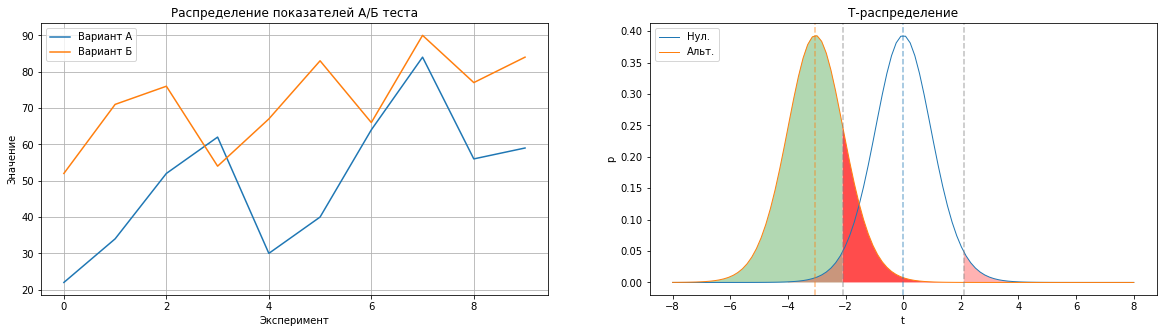

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.power as pwr

from math import sqrt
from scipy.stats import sem
from scipy.stats import t
from scipy.stats import norm
from termcolor import colored

pd.options.display.max_columns = 30
pd.options.display.width = 120
pd.options.display.float_format = '{:.3f}'.format

def calculate_stats(x1, x2, alpha=0.05):
    
    mu1, std1, v1, n1, se1 = prep_stats(x1)
    mu2, std2, v2, n2, se2 = prep_stats(x2)

    
    print_data = [['Параметры выборок', 'Вариант A', 'Вариант Б'],
        ['среднее', mu1, mu2],
#        ['стандартная ошибка', se1, se2],
        ['стандартное отклонение', std1, std2],
        ['дисперсия', v1, v2],
        ['N', n1, n2]]
    
    dash = '-' * 57

    for i in range(len(print_data)):
        if i == 0:
          print(dash)
          print('{:<27s}{:>15s}{:>15s}'.format(print_data[i][0],print_data[i][1],print_data[i][2]))
          print(dash)
        else:
          print('{:<27s}{:>15.3f}{:>15.3f}'.format(print_data[i][0],print_data[i][1],print_data[i][2]))
    
    print_diff(mu1, mu2)
    d, s_pooled = cohen_d(mu1, mu2, std1, std2, n1, n2)
    print("d %.3f" % d)
    print("s_pooled %.3f" % s_pooled)
    
    is_levene = levene_test(x1, x2)
    is_fisher = fisher_test((v1,v2), (n1,n2))

    #mu1=534.04
    #sd1=173.6246
    #n1=50
    
    #mu2=668.46
    #sd2=220.1796
    #n2=50
    
    #se = sqrt(std1*std1/n1 + std2*std2/n2)

    if is_levene and is_fisher:
        v = ((n1-1)*v1+(n2-1)*v2)/((n1-1)+(n2-1))
        t = (mu1 - mu2)/(sqrt(v*(1/n1+1/n2)))
        print("t = %.3f" % t)
    else:        
        se = sqrt(std1*std1/n1 + std2*std2/n2)
        t = (mu1 - mu2)/se

    df = n1 + n2 - 2
    
    # p-value, *2 because P(X < tt or X > tt)    
    p = stats.t.sf(np.abs(t), df)*2

    print_data = [['Расчет t-критерия', 'Значение'],
#        ['стандартная ошибка среднего', se],
        ['степеней свободы', df],
        ['t-коэффициент Стьюдента', t],
        ['p-уровень значимости', p]]
    
    dash = '-' * 42
    print("")    
    
    for i in range(len(print_data)):
        if i == 0:
          print(dash)
          print('{:<27s}{:>15s}'.format(print_data[i][0],print_data[i][1]))
          print(dash)
        else:
          print('{:<27s}{:>15.4f}'.format(print_data[i][0],print_data[i][1]))
    
    (cv1, cv2) = t_criteria_calc(p, t, df, alpha)
    #t_criteria_calc(p, t, df, 0.05)
    #t_criteria_calc(p, t, df, 0.01)
    
    power, nobs = calculate_power(d, n1, n2, alpha)    

    return (mu1, mu2), (std1, std2), (v1, v2), (n1, n2), (se1, se2), (cv1, cv2), t, p, df

def t_criteria_calc(p, t, df, alpha):

    cv1 = stats.t.ppf(alpha/2, df)     # criticl value
    cv2 = stats.t.ppf(1 - alpha/2, df)     # criticl value
    
    if t > cv1 and t < cv2:
        conclusion = 'в интервале'
    else:
        conclusion = 'вне интервала'
    
    print(colored("\nХарактеристики критерия t-Стьюдента (%d%%) :" % ((1-alpha)*100), attrs=['bold']))
    print("интервал принятия H0 гипотезы: [%.3f ; %.3f], %.4f %s" % (cv1, cv2, t, conclusion))

    if p > alpha:
        print(colored("%.3f > %.3f - результат получен случайно, средние значения тестов равны" % (p, alpha), "red"))
    else:
        print(colored("%.3f < %.3f - получен статистически значимый результат" % (p, alpha), "green"))  
        
    return cv1, cv2
           
def print_diff(mu1, mu2):
    if mu1 > mu2: 
        diff = (mu1/mu2-1)
        color = "red"
        prefix = "-"
    elif mu1 < mu2:
        diff = (mu2/mu1-1)
        color = "green"
        prefix = "+"
    else:
        diff = 0
        color = None
        prefix = ""

    print(colored("\nСреднее Б к среднему А:", attrs=['bold']))
    print(colored(prefix + "%.3f%%" % (diff * 100), color))

def prep_stats(data):
    mu = np.mean(data)
    std = np.std(data, ddof=1) # means devided by (N-1) instead N
    v = np.var(data, ddof=1)
    n = len(data)
    sem = stats.sem(data)
    
    return mu, std, v, n, sem;

def fisher_test(v, n, show_descr=False):
    v1, v2 = v
    n1, n2 = n
        
    f = v1/v2
    alpha=0.05
    fl = stats.f.ppf(alpha/2, (n1-1), (n2-1))
    fu = stats.f.ppf(1 - alpha/2, (n1-1), (n2-1))

    if show_descr:
        print(colored("\nПроверка одинаковости дисперсии через критерий Фишера", attrs=['bold']))
        print("Н0 - дисперсии равны, принимается при Fl < F < Fu")    
    
    if (fl < f and f < fu):
        if show_descr: print(colored("%.3f < %.3f < %.3f — принимается" % (fl, f, fu), "green"))
        return True
    else:
        if show_descr: print(colored("%.3f < %.3f < %.3f — отвергается" % (fl, f, fu), "red"))
        return False
    
    
def levene_test(data1, data2, show_descr=False):
    w, lp = stats.levene(x1, x2)
    
    if show_descr:
        print(colored("\nТест Левена на гомогенность дисперсий:", attrs=['bold']))
        print("p-уровень значимости: %.3f" % lp)
    
    #Как правило, гипотеза о равенстве (гомогенности) дисперсий не принимается, 
    # если тест Левена дает значение р < 0,05 (гетерогенность дисперсий)        
    if lp < 0.05:
        if show_descr: print(colored("%.3f < 0.05 - диспресии гетерогенны" % (lp), "red"))
        return False
    else:
        if show_descr: print(colored("%.3f > 0.05 - диспресии гомогенны" % (lp), "green"))
        return True

def cohen_d(mu1, mu2, sd1, sd2, n1, n2):
    n11 = n1-1
    n21 = n2-1
    s_pooled = sqrt((sd1*sd1*n11 + sd2*sd2*n21)/(n11+n21))
    d = abs(mu2-mu1)/s_pooled
    
    print(colored("\nРазмер эффекта по Кохену:", attrs=['bold']))
    
    if (d < 0.2):
        print("%.3f - нет эффекта" % d)
    elif (d < 0.5):
        print("%.3f - слабый эффект" % d)
    elif (d < 0.8):
        print("%.3f - средний эффект" % d)
    else:
        print("%.3f - сильный эффект" % d)
    
    return d, s_pooled

def calculate_power(effect_size, n1, n2, alpha):    
    
    print(colored("\nМощность критерия:", attrs=['bold']))
    
    if effect_size == 0:
        print("0.000")
        return 0, 0
    
    ratio=n2/n1    
    
    power = pwr.tt_ind_solve_power(effect_size=effect_size, nobs1=n1, alpha=alpha, power=None, ratio=ratio, alternative='two-sided')
    nobs = pwr.tt_ind_solve_power(effect_size=effect_size, nobs1=None, alpha=alpha, power=.8, ratio=ratio, alternative='two-sided')

    if nobs > n1:
        desc = "увеличьте количество экспериментов, нужно %d, сейчас %d" % (nobs, n1)
    else:
        desc = "экспериментов достаточно" # desc = "экспериментов достаточно, нужно %d, сейчас %d" % (nobs, n1)

    print("%.3f - %s" % (power, desc))
    
    return power, nobs

def plot_data(ax, data1, data2):
    ax.plot(data1)
    ax.plot(data2)
    ax.set_title('Распределение показателей А/Б теста')
    ax.set_ylabel('Значение')
    ax.set_xlabel('Эксперимент')
    ax.legend(['Вариант A', 'Вариант Б'], loc='upper left')
    ax.grid(True)
    

#data = pd.read_csv("pricelib_mobile.csv", sep=",", header=None)
data = pd.read_csv("csv/MoveToBookCard_list_lifehacks_unreg_desktop_20200210_1723.csv", sep=";", header=None)

x1 = data[2]
x2 = data[5]

x1 = [22,34,52,62,30,40,64,84,56,59]
x2 = [52,71,76,54,67,83,66,90,77,84]
# x2 = [22,34,52,62,30,40,64,84,56,59]

# plot data
gridsize = (1, 2)
fig = plt.figure(figsize=(20, 5))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))

plot_data(ax1, x1, x2);

# calculate data
alpha = 0.05

(mu1, mu2), (std1, std2), (v1, v2), (n1, n2), (se1, se2), (cv1, cv2), t, p, df = calculate_stats(x1, x2, alpha)

x = np.linspace(-8, 8, 100)
ax2.plot(x, stats.t.pdf(x, df), 'k', linewidth=1, color='#1f77b4')
ax2.plot(x, stats.t.pdf(x, df, loc=t), 'k', linewidth=1, color='#ff7f0e')
ax2.axvline(x=0, c='#1f77b4', alpha=0.5, linestyle='--')
ax2.axvline(x=t, c='#ff7f0e', alpha=0.5, linestyle='--')
ax2.axvline(x=cv1, c='gray', alpha=0.5, linestyle='--')
ax2.axvline(x=cv2, c='gray', alpha=0.5, linestyle='--')

ax2.set_title('Т-распределение')
ax2.set_ylabel('p')
ax2.set_xlabel('t')
ax2.legend(['Нул.', 'Альт.'], loc='upper left')

# Type-I errors
err1_lx = np.arange(-4, cv1, 0.01)
err1_rx = np.arange(cv2, 4, 0.01)

if t < 0:   
    # Power
    pow_x = np.arange(-8, cv1, 0.01)
    # Type-II error
    err2_x = np.arange(cv1, 4, 0.01)
else:
    # Power
    pow_x = np.arange(cv2, 8, 0.01)
    # Type-II error
    err2_x = np.arange(-4, cv2, 0.01)
    
    
ax2.fill_between(x=pow_x, y1=stats.t.pdf(pow_x, df, loc=t), facecolor='green', alpha=0.3)
ax2.fill_between(x=err1_lx, y1=stats.t.pdf(err1_lx, df), facecolor='red', alpha=0.3)
ax2.fill_between(x=err1_rx, y1=stats.t.pdf(err1_rx, df), facecolor='red', alpha=0.3)
ax2.fill_between(x=err2_x, y1=stats.t.pdf(err2_x, df, loc=t), facecolor='red', alpha=0.7)

plt.show()
